<a href="https://colab.research.google.com/github/Psaivignesh/Vignesh/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 06:53:05--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.60.60, 108.156.60.129, 108.156.60.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.60.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  11.0MB/s    in 7.2s    

2024-05-12 06:53:12 (6.25 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


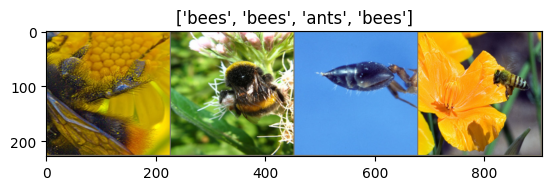

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5390 Acc: 0.7008

Epoch 1/4
----------
Loss: 0.5884 Acc: 0.7910

Epoch 2/4
----------
Loss: 0.3474 Acc: 0.8443

Epoch 3/4
----------
Loss: 0.3467 Acc: 0.8320

Epoch 4/4
----------
Loss: 0.3891 Acc: 0.8648



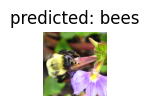

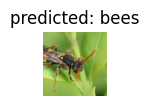

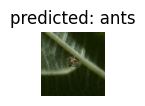

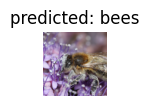

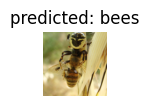

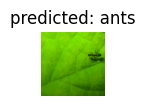

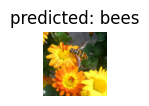

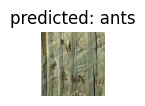

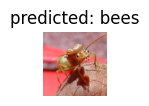

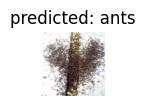

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


## 1st question answer:-

1.Increased Dataset Size: Data augmentation effectively increases the effective size of the training dataset by creating variations of the existing data. This helps prevent overfitting, where the model memorizes the training data instead of learning generalizable patterns.

2.Improved Generalization: By exposing the model to a diverse set of augmented samples during training, it learns to generalize better to variations it might encounter in real-world data. For example, a classifier trained on images augmented with random rotations will likely perform better on rotated images in deployment.

3.Robustness to Variations: Data augmentation helps the model become robust to various transformations or distortions that can occur naturally in real-world scenarios. For instance, an image classifier trained with random cropping and resizing can better handle images with different aspect ratios or resolutions.

4.Regularization: Data augmentation acts as a form of regularization by adding noise to the training process. This can help prevent the model from fitting the training data too closely and thus improve its ability to generalize to unseen data.

5.Addressing Class Imbalance: In classification tasks with imbalanced class distributions, augmentation can be used to generate additional samples for minority classes, thus alleviating the class imbalance problem and improving the model's ability to learn from these classes.

Overall, data augmentation is a crucial technique in machine learning for enhancing model performance, increasing dataset diversity, and promoting better generalization to unseen data.

## 2nd question answer:-

1.Limited Training Data: Training a deep neural network from scratch requires a large amount of labeled data to learn meaningful representations. Without pre-trained weights, the model has to start learning from random initialization, which often leads to suboptimal performance, especially with limited data.

2.Feature Learning: Pre-trained models like ResNet have been trained on large-scale datasets such as ImageNet, which enables them to learn generic features that are useful for a wide range of tasks. Starting from pre-trained weights allows the model to leverage these learned features, whereas training from scratch requires the model to learn such features from scratch as well, which is more challenging.

3.Computational Resources: Training deep neural networks from scratch can be computationally expensive and time-consuming, especially for large models like ResNet with many layers. Utilizing pre-trained weights allows you to leverage the computational resources already invested in training the model on a large dataset.

4.Overfitting: Training from scratch increases the risk of overfitting, especially if the dataset is small. Pre-trained models often come with regularization techniques already incorporated during pre-training, which helps prevent overfitting to some extent.

Therefore, if you train a ResNet model from scratch (by setting pretrained=False), you might observe lower performance compared to using pre-trained weights, especially if you have limited training data and computational resources. However, the exact performance would depend on various factors such as the dataset, model architecture, training parameters, and optimization strategy.

## 3rd question answer:-

1.Hierarchical Feature Learning: Pre-trained models like ResNet learn hierarchical representations of features from the input data. Lower layers capture basic features like edges and textures, while higher layers capture more abstract features like object parts and shapes. These hierarchical features are often transferable across different domains and tasks. For example, features learned from ImageNet, a dataset with a wide variety of object categories, can be useful for tasks like ants vs. bees classification.

2.Generic Features: Many features learned by pre-trained models are generic and broadly applicable. For instance, edges, textures, and color gradients are features relevant to various visual recognition tasks. While the specific objects or categories in the pre-training dataset may differ from those in the target task, the learned features can still be relevant and useful.

3.Fine-Tuning: Even though the pre-trained model was trained on a different dataset, you can fine-tune it on the ants vs. bees dataset. During fine-tuning, the model adapts its parameters to better fit the target task, while still retaining the useful features learned during pre-training. This helps the model adapt to the specifics of the new dataset.

However, there are some considerations:

4.Domain Shift: If the target dataset is significantly different from the pre-training dataset in terms of domain (e.g., medical images vs. natural images), there might be a domain shift, leading to a drop in performance. In such cases, domain adaptation techniques or training the model from scratch might be more appropriate.

5.Task-Specific Features: If the pre-training dataset is vastly different from the target dataset in terms of the types of objects or scenes present, the pre-trained features may not be as relevant. In such cases, fine-tuning may still help, but the performance improvement may not be as significant.

In summary, while using a pre-trained ResNet model on a dataset like ants vs. bees might not achieve optimal performance compared to training from scratch on a similar dataset, it can still provide a good starting point and significantly speed up the training process. Fine-tuning allows the model to adapt its learned features to the specifics of the target task.








